# TESTING CODE-HEIGHT MAP-MUSTAFA BAL

---



In [1]:
from google.colab import drive
drive.mount('/content/drive')
!nvidia-smi

Mounted at /content/drive
Sun Mar 20 12:08:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

In [2]:
main_dir = '/content/drive/My Drive/HeightMapPathLossPrediction/'

In [3]:
##IMPORTANT LIBRARIES
"""
@author: mbal
"""

from __future__ import print_function

import os, glob, sys, threading, random, warnings, fnmatch
import shutil, random, json, h5py, re, math

import cv2
# import glob2
import numpy as np

# # matplotlib.use('agg')
import matplotlib.pyplot as plt
# %matplotlib inline

import keras
from keras import optimizers
from keras import models
from keras import layers
from keras import backend as K
from keras.models import Model, load_model, Sequential


from keras.layers import Input, Flatten, Dense, Dropout, Conv2D, concatenate
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

from tensorflow.keras.optimizers import RMSprop,Adam, SGD

from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.losses import mean_squared_error
from keras.datasets import mnist
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16

# from tqdm import tqdm
from itertools import chain

import scipy.io
from scipy import ndimage, misc

import sklearn
import skimage.measure as measure
# from skimage.measure import compare_psnr
# from skimage.measure import compare_ssim as SSIM
from sklearn.metrics import classification_report, confusion_matrix

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label


# from google.colab import drive
from PIL import Image

from natsort import natsorted
from sklearn.utils import shuffle

os.environ["CUDA_VISIBLE_DEVICES"]="0"
print("Imported Tensorflow-Keras-OpenCV libraries")

Imported Tensorflow-Keras-OpenCV libraries


In [4]:
### NORMALIZATION
def normalize(input_data): #Normalizing the data
	return (input_data.astype(np.float32))/255

def denormalize(input_data): #Denormalizing the data
  input_data = (input_data) * 255
  return input_data.astype(np.uint8) 


In [5]:
# main_dir = 'C:/Users/mbal/Desktop/mustafabal/' ## Change this directory with your current folder.
# /content/drive/My Drive/Research/HeightMAP(CC)/HEIGHTMAP DATASET/HeightMAP_Intensity Mapped
import datetime
now = datetime.datetime.now()
date_time = now.strftime("%Y_%m_%d_%H_%M_%S")
def find_missing(lst,x):     
    return sorted(set(range(0, x )).difference(lst))

In [6]:
filename = main_dir+'Dataset/allnormalised224_900Mhz_300m_GITHUB_TEST.h5'
with h5py.File(filename, 'r') as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[:]


Keys: <KeysViewHDF5 ['HeightMapTest_GITHUB', 'NandSimgaTest_GITHUB', 'SatelliteTest_GITHUB']>


In [7]:
### LOADING THE DATA WITH THE TRAINED MODEL
def data_loader(Dataset_Folder):
  trn_file = h5py.File(main_dir+'Dataset/allnormalised224_'+Dataset_Folder+'_GITHUB_TEST.h5','r')
  
  X_test = trn_file['HeightMapTest_GITHUB'][:]
  Y_test= trn_file['NandSimgaTest_GITHUB'][:]
  
  maxY_trainS=24.156723022460938
  minY_testS=5.159702301025391
  maxY_trainN=3.750767230987549
  minY_testN=2.188645124435425
  
  print(maxY_trainS)
  print(maxY_trainN)
  print(minY_testS)
  print(minY_testN)
  
 
  Y_test[:,0]= Y_test[:,0]-minY_testN
  Y_test[:,0]= Y_test[:,0]/(maxY_trainN-minY_testN)
    
  Y_test[:,1]= Y_test[:,1]-minY_testS
  Y_test[:,1]= Y_test[:,1]/(maxY_trainS-minY_testS)
  
  print('X_test Size:',np.array(X_test).shape)
  print('Y_test Size:',np.array(Y_test).shape)

  print('X_test min-max: ',X_test.min(),X_test.max())
  print('Y_test N min-max: ',Y_test[:,0].min(),Y_test[:,0].max())
  print('Y_test S min-max: ',Y_test[:,1].min(),Y_test[:,1].max())
  print('-----shuffle-----')
 
  print('Y_test N Variance :',np.var(Y_test[:,0]))
  print('Y_test S Variance :',np.var(Y_test[:,1]))
  
  return X_test,Y_test

In [8]:
### TESTING RESULT- LOADING VGG-16 AND TRAINED WEIGHTS
X_test,Y_test = data_loader('900Mhz_300m')
# vgg_conv = models.load_model(main_dir+'Dataset/'+'vgg16_org.h5',compile=False) ## LOADING VGG-16 MODEL
vgg_conv = VGG16(include_top=True ,weights=main_dir+'Dataset/'+'vgg16_org.h5')
# # Create the model
Mustafa_Regression = models.Sequential()
# Add the vgg convolutional base model
for layer in vgg_conv.layers[:-1]: # just exclude last layer from copying
  Mustafa_Regression.add(layer)
# Mustafa_Regression.set_weights(vgg_conv.get_weights())
Mustafa_Regression.add(layers.Dense(2, activation='sigmoid'))
# Mustafa_Regression.summary()

# # ### CHANGE weights
Mustafa_Regression.load_weights(main_dir+'checkpoints/900Mhz_300m_All_Parameters_HEIGHT.hdf5') # 
# Mustafa_Regression.load_weights(main_dir+'checkpoints/900Mhz_300m_All_Parameters_SAT.hdf5') # 


# # #Predict on test
preds_test = Mustafa_Regression.predict(X_test, verbose=1)

24.156723022460938
3.750767230987549
5.159702301025391
2.188645124435425
X_test Size: (20, 224, 224, 3)
Y_test Size: (20, 2)
X_test min-max:  0.0 0.8705882352941177
Y_test N min-max:  0.10540558896766873 0.7984632208564846
Y_test S min-max:  0.16831904103551137 0.9560336388581825
-----shuffle-----
Y_test N Variance : 0.04919696296426514
Y_test S Variance : 0.03507623062000245
1/1 [==============================] - 10s 10s/step


In [9]:
## RESULTS
preds_N = preds_test[:,0]
preds_Sigma = preds_test[:,1]

maxY_trainS= 24.156723022460938
minY_testS= 5.159702301025391
maxY_trainN= 3.750767230987549
minY_testN=2.188645124435425

P_S_test=preds_Sigma*(maxY_trainS-minY_testS)
P_S_test=P_S_test+minY_testS
print(P_S_test.max())

P_N_test=preds_N*(maxY_trainN-minY_testN)
P_N_test=P_N_test+minY_testN
print(P_N_test.max())

Y_N_test=Y_test[:,0]*(maxY_trainN-minY_testN)
Y_N_test=Y_N_test+minY_testN
print(Y_N_test.max())

Y_S_test=Y_test[:,1]*(maxY_trainS-minY_testS)
Y_S_test=Y_S_test+minY_testS
print(Y_S_test.max())

print('Denormalized MSE N: ',np.mean((Y_N_test-P_N_test)**2))
print('Denormalized MSE Sigma: ',np.mean((Y_S_test-P_S_test)**2))

19.643867
3.516158
3.4359421730041504
23.32149314880371
Denormalized MSE N:  0.010712398875153895
Denormalized MSE Sigma:  12.504785951567374


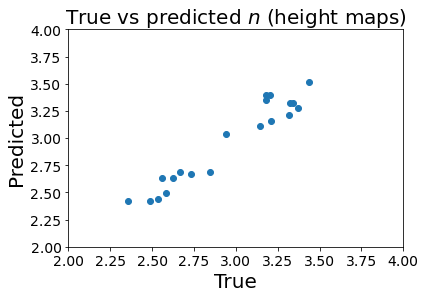

In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
fig3=plt.figure()
plt.xlim(2,4)
plt.ylim(2,4)
plt.scatter(Y_N_test, P_N_test)
plt.xlabel("True",fontsize='20')
plt.ylabel("Predicted",fontsize='20')
plt.title("True vs predicted $n$ (height maps)",fontsize='20')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
# plt.savefig("C:/Users/mbal/Desktop/mustafabal/Wireless Communication Letter Reviews/WC_ALLPARAMETERS_HEIGHT_N_Scatter_VGG16.pdf",bbox_inches='tight')
plt.show()

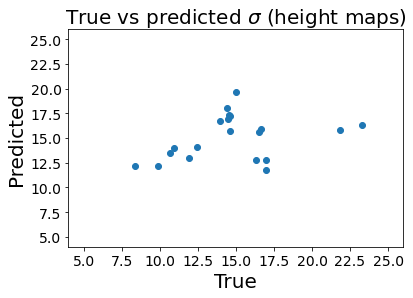

In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
fig3=plt.figure()
plt.xlim(4,26)
plt.ylim(4,26)
plt.scatter(Y_S_test, P_S_test)
plt.xlabel("True",fontsize='20')
plt.ylabel("Predicted",fontsize='20')
plt.title("True vs predicted $\sigma$ (height maps)",fontsize='20')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
# plt.savefig("C:/Users/mbal/Desktop/mustafabal/Wireless Communication Letter Reviews/WC_ALLPARAMETERS_HEIGHT_Sigma_Scatter_VGG16.pdf",bbox_inches='tight')
plt.show()

(20,)
Sorted 2D Numpy Array
2.353301525115967 2.4243693351745605


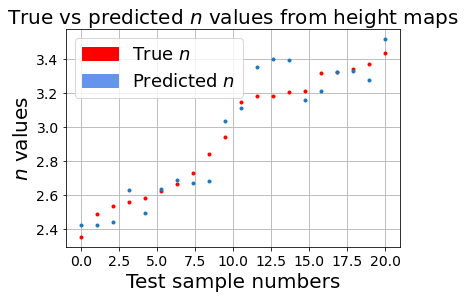

In [12]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import matplotlib.patches as mpatches
m = np.array((np.array(Y_N_test),np.array(P_N_test)))
# print(m[0][0],m[1][0])Y_S_test=Y_train[:,1]*(maxY_trainS-minY_testS)
# Y_S_test=Y_S_test+minY_testS
print(Y_S_test.shape)
sortedArr = m [ :, m[0].argsort()]
print('Sorted 2D Numpy Array')
print(sortedArr[0][0],sortedArr[1][0])
GT=sortedArr[0]
Pred=sortedArr[1]
fig1=plt.figure()
x1 = np.linspace(0, 20, 20)
plt.plot(x1,GT,'r.',x1,Pred,'.')
plt.xlabel("Test sample numbers",fontsize='20')
plt.ylabel("$n$ values",fontsize='20')
plt.title("True vs predicted $n$ values from height maps",fontsize='20')
red_patch = mpatches.Patch(color='red', label='True $n$')
blue_patch = mpatches.Patch(color='cornflowerblue', label='Predicted $n$')
plt.legend(handles=[red_patch,blue_patch],prop={"size":18})
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.grid(True)
# plt.savefig("C:/Users/mbal/Desktop/mustafabal/Wireless Communication Letter Reviews/AllParameters_HEIGHT_N.pdf",bbox_inches='tight')

Sorted 2D Numpy Array
8.35726261138916 12.199304580688477


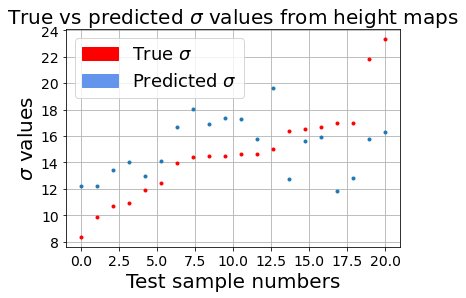

In [13]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import matplotlib.patches as mpatches
m = np.array((np.array(Y_S_test),np.array(P_S_test)))
# print(m[0][0],m[1][0])
sortedArr = m [ :, m[0].argsort()]
print('Sorted 2D Numpy Array')
print(sortedArr[0][0],sortedArr[1][0])
GT=sortedArr[0]
Pred=sortedArr[1]
fig1=plt.figure()
x1 = np.linspace(0, 20, 20)
plt.plot(x1,GT,'r.',x1,Pred,'.')
plt.xlabel("Test sample numbers",fontsize='20')
plt.ylabel("$\sigma$ values",fontsize='20')
plt.title("True vs predicted $\sigma$ values from height maps",fontsize='20')
red_patch = mpatches.Patch(color='red', label='True $\sigma$')
blue_patch = mpatches.Patch(color='cornflowerblue', label='Predicted $\sigma$')
plt.legend(handles=[red_patch,blue_patch],prop={"size":18})
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.grid(True)
# plt.savefig("C:/Users/mbal/Desktop/mustafabal/Wireless Communication Letter Reviews/AllParameters_HEIGHT_Sigma.pdf",bbox_inches='tight')

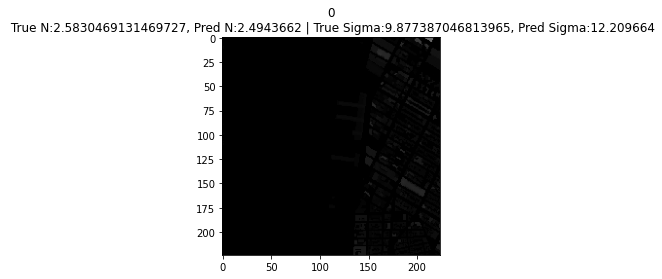

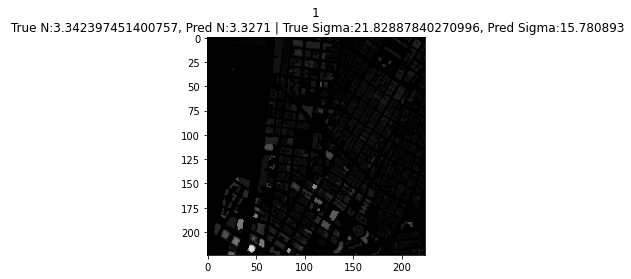

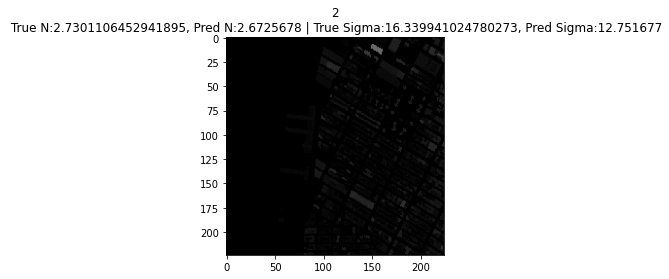

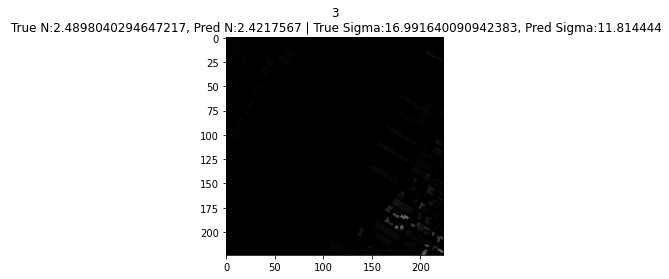

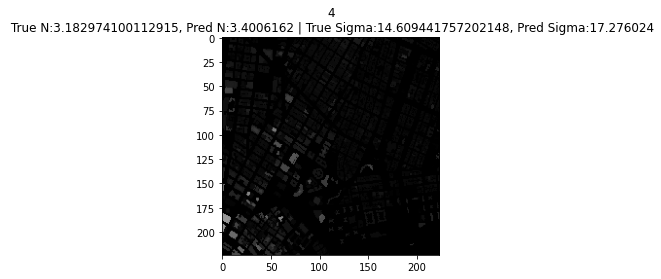

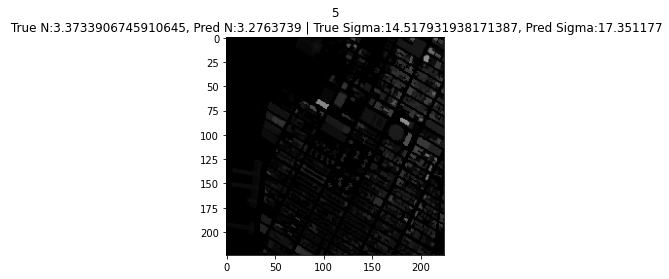

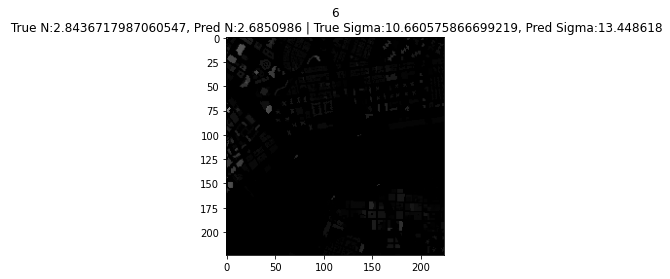

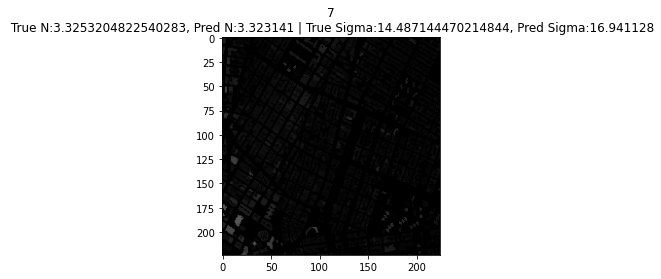

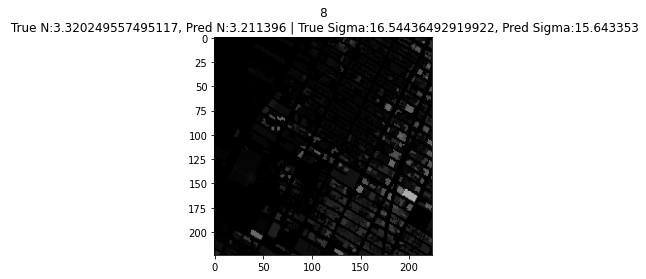

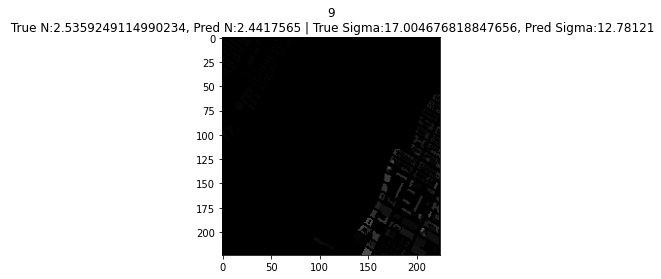

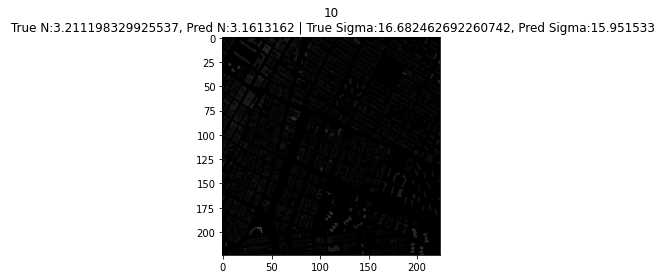

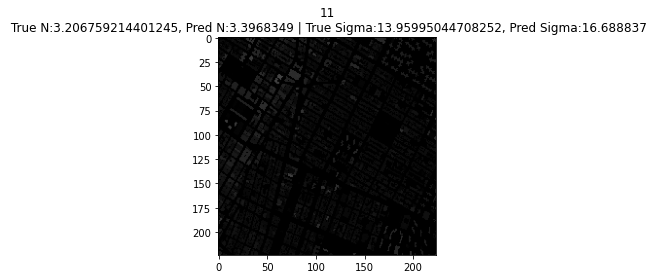

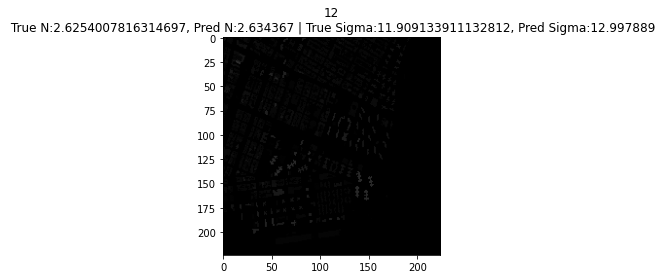

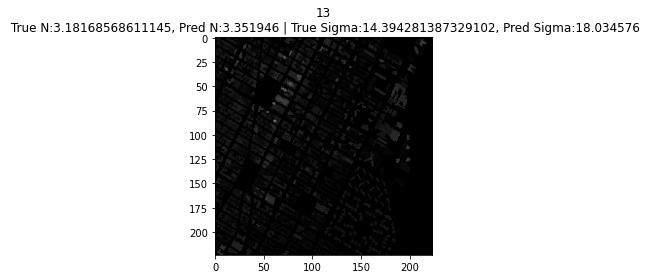

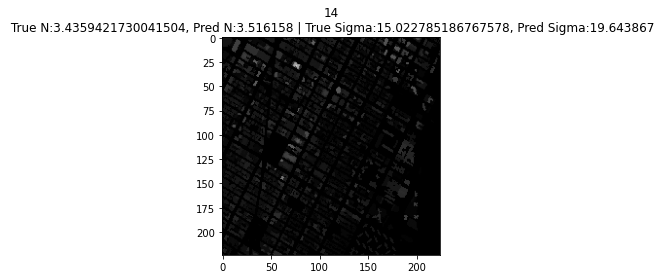

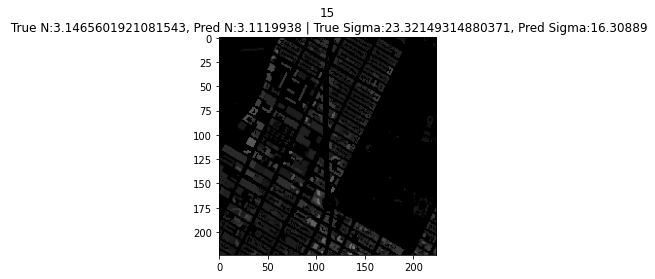

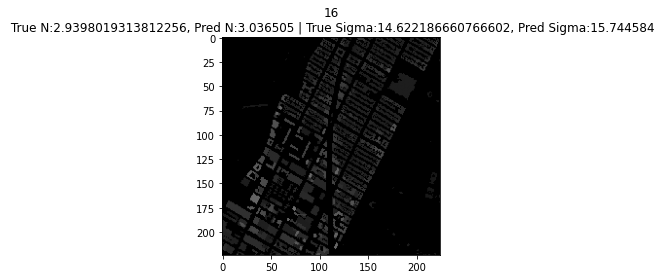

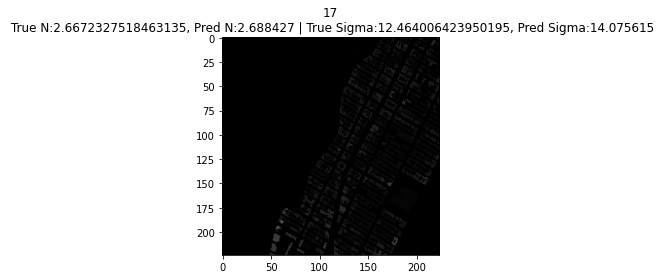

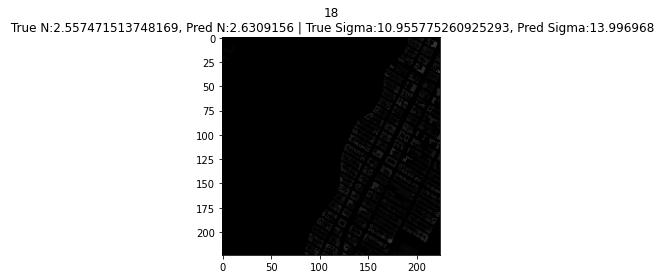

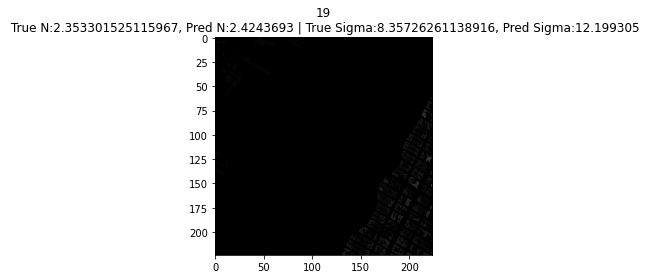

In [15]:
image_numbers=list(range(0,20))
for i in range(0,len(image_numbers)):
  new_image=X_test[i]
  fig=plt.figure()
  plt.imshow(new_image)
  plt.title(str(image_numbers[i])+"\n True N:"+str(Y_N_test[i])+", Pred N:"+str(P_N_test[i])+" | True Sigma:"+str(Y_S_test[i])+", Pred Sigma:"+str(P_S_test[i]))